In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
import os

In [2]:
baseline_df = pd.read_csv('Curated_Data_Cuts_Files/PPMI_Baseline_Data_02Jul2018.csv')
years_df = pd.read_csv('Curated_Data_Cuts_Files/PPMI_Year_1-3_Data_02Jul2018.csv')
mri_df = pd.read_csv('mri_t2_progression.csv')

print(baseline_df['PATNO'].value_counts().index)

Int64Index([3071, 3386, 3400, 4074, 4093, 3392, 4082, 3390, 3389, 3387,
            ...
            3756, 3755, 3754, 3753, 3752, 3751, 3750, 4085, 4037, 3072],
           dtype='int64', length=683)


In [3]:
## Get patient numbers with critical info and MRI scans
mri_patno_counts = mri_df['Subject'].value_counts()
mri_ids = mri_patno_counts.index

baseline_df = baseline_df[baseline_df['PATNO'].isin(mri_ids)]
years_df = years_df[years_df['PATNO'].isin(mri_ids)]

In [4]:
print(baseline_df['PATNO'].value_counts().index)

Int64Index([4085, 4135, 3362, 3364, 3368, 3369, 3010, 3374, 3375, 3377,
            ...
            3638, 3650, 3651, 3653, 3654, 3656, 3657, 3658, 3659, 4121],
           dtype='int64', length=419)


In [5]:
## Define biomarkers to keep from each set
years_col = years_df.columns
bl_col = baseline_df.columns
same_col = years_col.intersection(bl_col)
only_years_col = years_col.drop(same_col)
# print(only_years_col)
only_bl_col = bl_col.drop(same_col)
# print(only_bl_col)

only_bl_bm_col = only_bl_col.drop(['symptom5_comment', 'symptom6', 'APOE', 'SNCA_rs356181', 'SNCA_rs3910105', 'MAPT'])
both_bm_col = same_col.drop([
    'SITE', 'NHY'
])

In [6]:
## Create dataframe with selected biomarkers
only_bl_bm_df = baseline_df[only_bl_bm_col.append(pd.Index(['PATNO']))]

years_bm_df = years_df[both_bm_col.append(pd.Index(['YEAR']))]
years_bm_df = years_bm_df.merge(only_bl_bm_df, on='PATNO', suffixes=(False, '_bl'))
years_bm_df.index = pd.Index([i for i in range(years_bm_df.shape[0])])
print(years_bm_df.shape)

bl_bm_df = baseline_df[both_bm_col.append(only_bl_bm_col)]
bl_bm_df['YEAR'] = pd.Series([0 for i in range(bl_bm_df.shape[0])])
bl_bm_df.index = pd.Index([i + years_bm_df.shape[0] for i in range(bl_bm_df.shape[0])])
print(bl_bm_df.shape)

events_df = years_bm_df.append(bl_bm_df)
print(events_df.shape)
print(events_df['hy'].value_counts())

(1184, 128)
(419, 128)
(1603, 128)
2    585
0    554
1    311
.    120
3     33
Name: hy, dtype: int64


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [7]:
## Standardize null format, keep biomarkers with >=80% representation
events_df_nulls = events_df.replace('.', np.nan)
col_nulls = events_df_nulls.isnull().sum(axis = 0) / events_df.shape[0]
print(col_nulls['race'])
events_col_keep = [i for i in (col_nulls < 0.2).index if (col_nulls < 0.2)[i]]
events_populated = events_df_nulls[events_col_keep]
print(events_populated.shape)

0.0
(1603, 81)


In [8]:
## Remove rows with nulls from merged data
events_hasna = events_populated[events_populated.isna().any(axis=1)]
drop_rows = events_hasna.index
events_bm = events_populated.drop(drop_rows)
print(events_bm.shape)

(906, 81)


In [9]:
## Convert numeric entries to number variable types
for i in events_bm.columns:
    events_bm[i] = pd.to_numeric(events_bm[i], errors='ignore')

In [10]:
print(events_bm['hy'].value_counts())
print(events_bm['APPRDX'].value_counts())
print(events_bm['gen'].value_counts())
print(events_bm['race'].value_counts())
print(events_bm['age_cat'].value_counts())

2    365
0    349
1    177
3     15
Name: hy, dtype: int64
1    550
2    356
Name: APPRDX, dtype: int64
1    624
2    282
Name: gen, dtype: int64
1    853
4     26
2     24
3      3
Name: race, dtype: int64
2    353
1    277
3    276
Name: age_cat, dtype: int64


In [11]:
## Create dataframe of stage progressions for each patient
patnos = events_bm['PATNO'].value_counts().index

def stage_row(patno):
    dur = baseline_df[baseline_df['PATNO'] == patno]['duration'].iloc[0]
    bl_hy = baseline_df[baseline_df['PATNO'] == patno]['hy'].iloc[0]
    
    years_rows = years_df[years_df['PATNO'] == patno]
    
    y1 = years_rows[years_rows['YEAR'] == 1]
    if (y1.shape[0] > 0):
        y1_hy = y1['hy'].iloc[0]
    else:
        y1_hy = '.'
        
    y2 = years_rows[years_rows['YEAR'] == 2]
    if (y2.shape[0] > 0):
        y2_hy = y2['hy'].iloc[0]
    else:
        y2_hy = '.'
        
    y3 = years_rows[years_rows['YEAR'] == 3]
    if (y3.shape[0] > 0):
        y3_hy = y3['hy'].iloc[0]
    else:
        y3_hy = '.'
    
    new_row = pd.DataFrame([[patno, dur, bl_hy, y1_hy, y2_hy, y3_hy]])
    return new_row

stage_df = pd.concat([stage_row(i) for i in patnos], ignore_index=True)
stage_df.columns = ['PATNO', 'duration', 'bl_hy', 'y1_hy', 'y2_hy', 'y3_hy']

# print(stage_df)

In [12]:
## Assign progression label to each entry
def prog_label(row_index):
    event_row = events_bm.loc[row_index]
    pat_row = stage_df[stage_df['PATNO'] == event_row['PATNO']]
    visit = event_row['YEAR']
    
    bl = pat_row['bl_hy'].iloc[0]
    y1 = pat_row['y1_hy'].iloc[0]
    y2 = pat_row['y2_hy'].iloc[0]
    y3 = pat_row['y3_hy'].iloc[0]
    
    if visit == 0 and bl != '.' and y1 != '.':
        label = int(y1 > bl)
    elif visit == 1 and y1 != '.' and y2 != '.':
        label = int(y2 > y1)
    elif visit == 2 and y2 != '.' and y3 != '.':
        label = int(y3 > y2)
    else:
        label = -1
    
    return label

events_bm['Progression'] = [prog_label(i) for i in events_bm.index]

In [13]:
events_prog = events_bm[events_bm['Progression'] != -1]

events_race = events_prog['race']
race_onehot = np.zeros((events_prog.shape[0], 4))
race_onehot[np.arange(events_prog.shape[0]), events_race-1] = 1
race_df = pd.DataFrame(race_onehot, columns=['race_white', 'race_black', 'race_asian', 'race_other'])
race_df.index = events_prog.index

events_prog.drop(['race'], axis=1)
events_prog = events_prog.join(race_df)

events_prog.to_csv('events_biomarkers.csv')

In [14]:
x_cols = events_prog.columns.drop(['YEAR', 'EVENT_ID', 'PATNO', 'Progression', 'hy', 'APPRDX'])
events_x = events_prog[x_cols]
events_y = events_prog['Progression']

In [15]:
events_y.value_counts()

0    565
1     78
Name: Progression, dtype: int64

In [16]:
events_x_norm = pd.DataFrame(stats.zscore(events_x, axis=0, ddof=1))
print(events_x_norm.head(1))

         0         1         2         3         4         5         6   \
0 -0.556829 -0.052592  0.188073 -0.734601 -0.253186  0.544374  0.976363   

         7         8         9   ...        70        71        72       73  \
0  1.199577 -0.352352 -0.453611  ... -0.864443 -0.234076 -0.849879 -0.57158   

        74        75        76        77        78        79  
0 -0.64558  1.786644  0.246903 -0.164664 -0.055815 -0.169574  

[1 rows x 80 columns]


In [17]:
## Create train, test, valid sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(events_x, events_y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [18]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_auc_score

def select_best_model(train_X, train_y, valid_X, valid_y, C_options, penalty_options):
    best_model, best_C, best_penalty, best_score = None, None, None, 0 
    for C in C_options:
        for penalty in penalty_options:
            model = LogisticRegression(C=C, penalty=penalty).fit(train_X, train_y)
            train_pred = [p[1] for p in model.predict_proba(train_X)]
            train_auc = roc_auc_score(train_y, train_pred)
            valid_pred = [p[1] for p in model.predict_proba(valid_X)]
            valid_auc = roc_auc_score(valid_y, valid_pred)
            print("C=" + str(C) + " | p=" + penalty + " :: train AUC=" + str(train_auc) + " ; valid AUC=" + str(valid_auc))
            if valid_auc > best_score:
                best_model, best_C, best_penalty, best_score = model, C, penalty, valid_auc
    print("Best model: C = " + str(best_C) + ", penalty: " + str(best_penalty))
    return best_model

model = select_best_model(X_train, y_train, X_val, y_val, [0.01, 0.1, 0.25, 0.5, 1], ['l1', 'l2'])
test_pred = [p[1] for p in model.predict_proba(X_test)]
print("test AUC: ", roc_auc_score(y_test, test_pred))

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

C=0.01 | p=l1 :: train AUC=0.6846565566458519 ; valid AUC=0.4268774703557312
C=0.01 | p=l2 :: train AUC=0.7945286946179007 ; valid AUC=0.49011857707509876
C=0.1 | p=l1 :: train AUC=0.7778273367033403 ; valid AUC=0.5187747035573123
C=0.1 | p=l2 :: train AUC=0.83843790266627 ; valid AUC=0.49901185770750983
C=0.25 | p=l1 :: train AUC=0.8246605213598969 ; valid AUC=0.5039525691699605
C=0.25 | p=l2 :: train AUC=0.8486966002577063 ; valid AUC=0.4940711462450593
C=0.5 | p=l1 :: train AUC=0.8395777579542074 ; valid AUC=0.4822134387351778
C=0.5 | p=l2 :: train AUC=0.8546436713252057 ; valid AUC=0.48221343873517786
C=1 | p=l1 :: train AUC=0.8464664486073943 ; valid AUC=0.4782608695652174
C=1 | p=l2 :: train AUC=0.8600455942115175 ; valid AUC=0.47430830039525684
Best model: C = 0.1, penalty: l1
test AUC:  0.6974789915966386


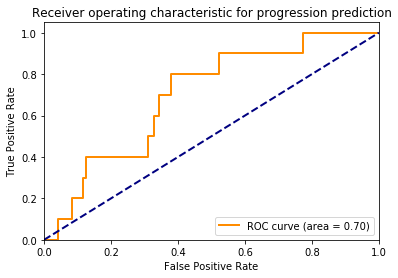

In [19]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, test_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for progression prediction')
plt.legend(loc="lower right")
plt.show()

In [28]:
def sort_features(model, features):
    coef = model.coef_
    feature_coef = [(features[i], coef[0,i]) for i in range(len(features))]
    sorted_feature_coef = sorted(feature_coef, key=lambda x: -x[1]) 
    return sorted_feature_coef

def display_most_predictive_features(sorted_features, n, positive=True): 
    if positive:
        for i in range(n):
            print(sorted_features[i][0] + ": " + str(sorted_features[i][1]))
    else:
        for i in range(len(sorted_features) - 1, len(sorted_features) - 1 - n, -1):
            print(sorted_features[i][0] + ": " + str(sorted_features[i][1]))

feat = sort_features(model, list(events_x.columns))
print("MOST POSIVITE ++")
display_most_predictive_features(feat, 10)
print()
print("MOST NEGATIVE --")
display_most_predictive_features(feat, 10, False)
print()
display_most_predictive_features(feat, 80)

MOST POSIVITE ++
scopa_gi: 0.057875272698698584
tremor: 0.048599598759865165
hvlt_immediaterecall: 0.02972475656898236
updrs2_score: 0.022020461781223164
moca: 0.018033036239282464
scopa_sex: 0.01793884529437788
VLTANIM: 0.014519980034604744
updrs_totscore: 0.009884111664609584
stai_trait: 0.007433777232365605
sft: 0.004338265999895547

MOST NEGATIVE --
td_pigd_old: -0.3098806522753787
rigidity: -0.08728229339807902
ess: -0.06691699330871362
rem: -0.024076209992527967
SNCA_rs356181_cat: -0.021075782330976935
age: -0.013739240289120772
lns: -0.010687994841768618
SDMTOTAL: -0.010611100514752718
tau: -0.01009412800603597
HVLTRDLY: -0.004735920655484472

scopa_gi: 0.057875272698698584
tremor: 0.048599598759865165
hvlt_immediaterecall: 0.02972475656898236
updrs2_score: 0.022020461781223164
moca: 0.018033036239282464
scopa_sex: 0.01793884529437788
VLTANIM: 0.014519980034604744
updrs_totscore: 0.009884111664609584
stai_trait: 0.007433777232365605
sft: 0.004338265999895547
hvlt_discrimination: